In [1]:
# ===============================================================
# 🌟 Colab GPU Optimized Resume Ranking & Analysis using BERT
# ===============================================================

# ✅ Install Transformers if not already installed
!pip install transformers --quiet

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


2025-10-27 02:12:52.711006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761531172.943651      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761531173.004544      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ======================
# GPU Check
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)

✅ Device: cuda


In [3]:


# ======================
# Load Dataset
# ======================
csv_path = "/kaggle/input/cv-resume/dataset.csv"  # Upload your dataset to Colab path
df = pd.read_csv(csv_path)

print("Columns in CSV:", df.columns.tolist())
print(df.head())

texts = df["Resume"].astype(str).tolist()
job_roles = df["Role"].astype(str).tolist()
job_desc = df["Job_Description"].astype(str).tolist()
labels_text = df["Decision"].astype(str).tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_text)
print("\nLabel mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Columns in CSV: ['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description']
                         Role  \
0       E-commerce Specialist   
1              Game Developer   
2  Human Resources Specialist   
3       E-commerce Specialist   
4       E-commerce Specialist   

                                              Resume Decision  \
0  Here's a professional resume for Jason Jones:\...   reject   
1  Here's a professional resume for Ann Marshall:...   select   
2  Here's a professional resume for Patrick Mccla...   reject   
3  Here's a professional resume for Patricia Gray...   select   
4  Here's a professional resume for Amanda Gross:...   reject   

                                 Reason_for_decision  \
0    Lacked leadership skills for a senior position.   
1              Strong technical skills in AI and ML.   
2  Insufficient system design expertise for senio...   
3  Impressive leadership and communication abilit...   
4    Lacked leadership skills for a senio

In [4]:
# ======================
# Data Split (Show %)
# ======================
train_ratio, val_ratio, test_ratio = 0.8, 0.15, 0.15
train_texts, temp_texts, train_labels, temp_labels, train_job_roles, temp_job_roles, train_job_desc, temp_job_desc = train_test_split(
    texts, labels, job_roles, job_desc, test_size=(1-train_ratio), random_state=42
)
val_texts, test_texts, val_labels, test_labels, val_job_roles, test_job_roles, val_job_desc, test_job_desc = train_test_split(
    temp_texts, temp_labels, temp_job_roles, temp_job_desc, test_size=test_ratio/(val_ratio+test_ratio), random_state=42
)

print(f"\n📊 Data Split Summary:")
print(f"Train: {len(train_texts)} ({train_ratio*100:.0f}%)")
print(f"Validation: {len(val_texts)} ({val_ratio*100:.0f}%)")
print(f"Test: {len(test_texts)} ({test_ratio*100:.0f}%)")



📊 Data Split Summary:
Train: 8139 (80%)
Validation: 1017 (15%)
Test: 1018 (15%)


In [5]:
# ======================
# Tokenizer
from transformers import BertTokenizer

# Kaggle input folder path ব্যবহার করো
tokenizer_path ="/kaggle/input/ksdfoieeknf/bert_local"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, use_fast=False)

# Test
text = "This is a test."
encoding = tokenizer(text)
print("✅ Tokenizer loaded successfully!")          

✅ Tokenizer loaded successfully!


In [6]:
# আগে যেটা ছিল
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# replace করে local path use করো
tokenizer_path = "/kaggle/input/ksdfoieeknf/bert_local"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, use_fast=False)

In [7]:
print("✅ Tokenizer loaded successfully!")
print(tokenizer.tokenize("This is a working BERT tokenizer test."))

✅ Tokenizer loaded successfully!
['this', 'is', 'a', 'working', 'bert', 'token', '##izer', 'test', '.']


In [8]:
# ======================
# Dataset Class
# ======================
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [9]:
# ======================
# DataLoader
# ======================
batch_size = 128
train_dataset = ResumeDataset(train_texts, train_labels, tokenizer)
val_dataset = ResumeDataset(val_texts, val_labels, tokenizer)
test_dataset = ResumeDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# ======================
# Model
# ======================
class ResumeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        return self.fc(cls_output)

model = ResumeClassifier(num_classes=len(set(labels))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
# ======================
# Training & Evaluation
# ======================
train_losses, val_losses, train_accs, val_accs = [], [], [], []

def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.inference_mode():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    acc = 100 * correct / total
    return acc, all_preds, all_labels, all_probs

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=3):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc, _, _, _ = evaluate(model, val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(1 - val_acc / 100)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    end_time = time.time()
    print(f"\nTotal Training Time: {end_time - start_time:.2f} sec")


In [12]:
# Train model
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)


Epoch 1/10: 100%|██████████| 64/64 [04:01<00:00,  3.78s/it]


Epoch 1: Train Loss=0.6821, Train Acc=52.99%, Val Acc=56.24%


Epoch 2/10: 100%|██████████| 64/64 [04:11<00:00,  3.92s/it]


Epoch 2: Train Loss=0.6333, Train Acc=56.24%, Val Acc=57.03%


Epoch 3/10: 100%|██████████| 64/64 [04:11<00:00,  3.92s/it]


Epoch 3: Train Loss=0.6111, Train Acc=58.90%, Val Acc=56.93%


Epoch 4/10: 100%|██████████| 64/64 [04:11<00:00,  3.92s/it]


Epoch 4: Train Loss=0.5965, Train Acc=60.28%, Val Acc=58.11%


Epoch 5/10: 100%|██████████| 64/64 [04:11<00:00,  3.93s/it]


Epoch 5: Train Loss=0.5773, Train Acc=62.34%, Val Acc=57.82%


Epoch 6/10: 100%|██████████| 64/64 [04:10<00:00,  3.92s/it]


Epoch 6: Train Loss=0.5679, Train Acc=65.00%, Val Acc=56.24%


Epoch 7/10: 100%|██████████| 64/64 [04:11<00:00,  3.93s/it]


Epoch 7: Train Loss=0.5409, Train Acc=68.76%, Val Acc=57.62%


Epoch 8/10: 100%|██████████| 64/64 [04:11<00:00,  3.93s/it]


Epoch 8: Train Loss=0.5006, Train Acc=72.75%, Val Acc=57.72%


Epoch 9/10: 100%|██████████| 64/64 [04:11<00:00,  3.92s/it]


Epoch 9: Train Loss=0.4482, Train Acc=77.11%, Val Acc=57.13%


Epoch 10/10: 100%|██████████| 64/64 [04:11<00:00,  3.92s/it]


Epoch 10: Train Loss=0.3695, Train Acc=82.48%, Val Acc=57.13%

Total Training Time: 2659.02 sec


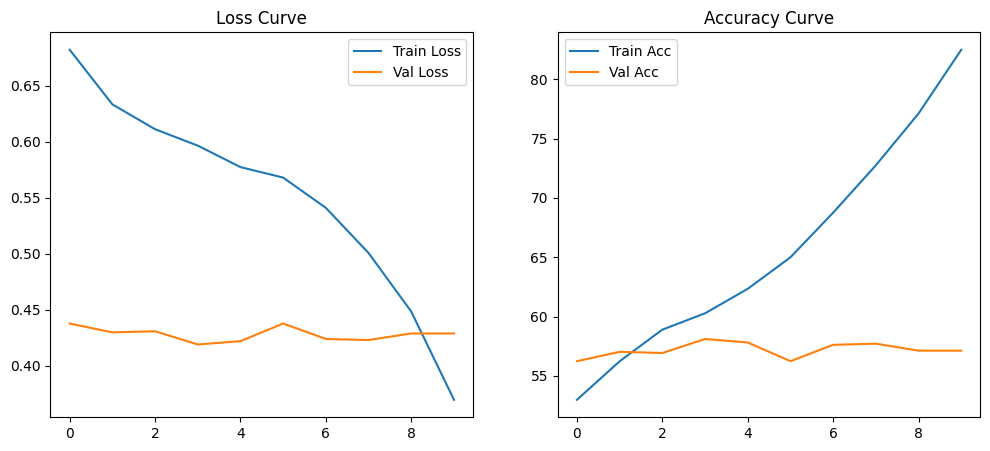

In [13]:
# ======================
# Plot Curves
# ======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()


✅ Test Accuracy: 59.04%


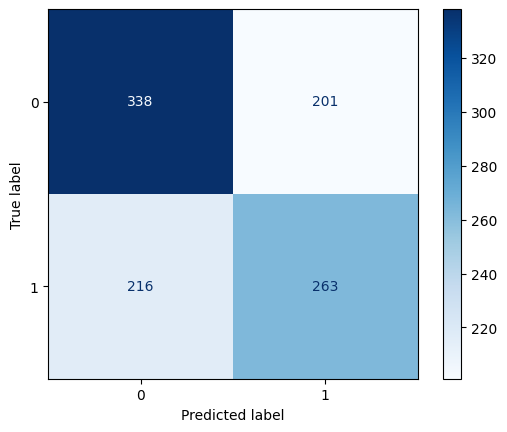

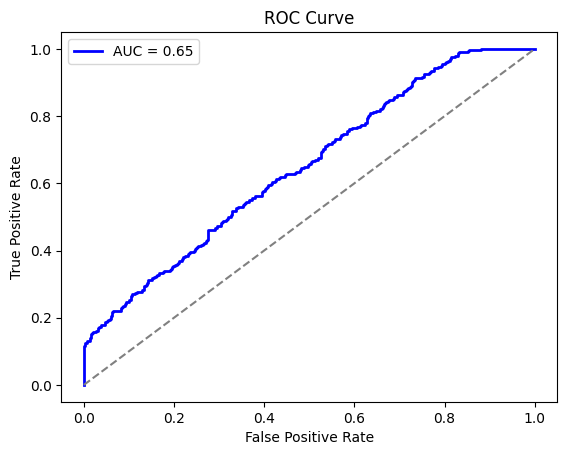

In [14]:
# ======================
# Test Evaluation
# ======================
test_acc, test_preds, test_labels_actual, test_probs = evaluate(model, test_loader)
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")

cm = confusion_matrix(test_labels_actual, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()

fpr, tpr, _ = roc_curve(test_labels_actual, test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()


In [15]:

  # Rank Top 10 Resumes
all_resumes = []
model.eval()
with torch.inference_mode():
    for i in range(len(test_texts)):
        encoding = tokenizer(test_texts[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        score, pred_class = torch.max(probs, dim=1)
        all_resumes.append({
            "Role": test_job_roles[i],
            "Resume": test_texts[i],
            "Job_Description": test_job_desc[i],
            "Predicted_Label": label_encoder.inverse_transform([pred_class.item()])[0],
            "Score": score.item()
        })

ranked_resumes = sorted(all_resumes, key=lambda x: x["Score"], reverse=True)

print("\n===== Top 10 Ranked Resumes =====\n")
for idx, r in enumerate(ranked_resumes[:10], 1):
    print(f"Rank {idx}: Role = {r['Role']}, Predicted = {r['Predicted_Label']}, Score = {r['Score']:.4f}")
    print(f"Job Description: {r['Job_Description']}")
    print(f"Resume: {r['Resume'][:200]}...\n")
    print("-"*80)




===== Top 10 Ranked Resumes =====

Rank 1: Role = data engineer, Predicted = reject, Score = 0.9997
Job Description: demonstrated limited understanding of job requirements., had insufficient experience for the position.
Resume: **confidential candidate profile: charvi choudhury**

**summary:**
charvi choudhury is a detail-oriented and analytical individual with a background in computer science. although she demonstrated a so...

--------------------------------------------------------------------------------
Rank 2: Role = product manager, Predicted = reject, Score = 0.9997
Job Description: lacked key technical skills for the role., had insufficient experience for the position.
Resume: **candidate profile: brinda bhardwaj**

**interview for product manager role**

**strengths:**

* brinda demonstrated a strong passion for product development and a keen interest in understanding cust...

--------------------------------------------------------------------------------
Rank 3: Role = dat

In [16]:
# ======================
# Single Resume Check
# ======================
single_path = "/kaggle/input/single-data-set-for-cv-resume-3/Emma Johnson.txt"  # Upload single resume file
with open(single_path, "r", encoding="utf-8") as f:
    resume_text = f.read()  # ✅ make sure variable name matches

# Tokenize
encoding = tokenizer(resume_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

# Model prediction
model.eval()
with torch.inference_mode():
    outputs = model(input_ids, attention_mask)
    probs = torch.softmax(outputs, dim=1)
    score, pred_class = torch.max(probs, dim=1)
    predicted_label = label_encoder.inverse_transform([pred_class.item()])[0]

print(f"Prediction: {predicted_label}, Confidence: {score.item():.4f}")

# Suggestions
if predicted_label != 'Hire':
    print("\n💡 To improve this CV:")
    print("- Highlight key skills relevant to the Role.")
    print("- Include quantified achievements or project outcomes.")
    print("- Ensure keywords match the Job Description.")
else:
    print("\n✅ This CV is already strong for the given role!")


Prediction: reject, Confidence: 0.9090

💡 To improve this CV:
- Highlight key skills relevant to the Role.
- Include quantified achievements or project outcomes.
- Ensure keywords match the Job Description.
